In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\prate\Anaconda2\envs\MyEnvDL\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [ ]:
IPython.display.Audio("./raw_data/activates/1.wav")

In [ ]:
IPython.display.Audio("./raw_data/negatives/4.wav")

In [ ]:
IPython.display.Audio("./raw_data/backgrounds/2.wav")

In [ ]:
IPython.display.Audio("audio_examples/example_train.wav")

In [3]:
# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

In [4]:
# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

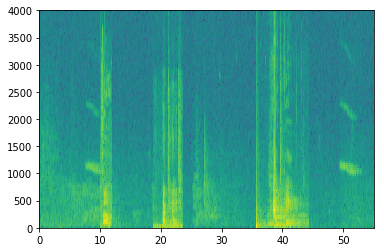

In [5]:
x = graph_spectrogram("audio_examples/example_train.wav")

In [7]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1375 # The number of time steps in the output of our model

In [9]:
# Load raw audio files for speech synthesis
def load_raw_audio():
    activates = []
    backgrounds = []
    negatives = []
    for filename in os.listdir("./raw_data/activates"):
        if filename.endswith("wav"):
            activate = AudioSegment.from_wav("./raw_data/activates/"+filename)
            activates.append(activate)
    for filename in os.listdir("./raw_data/backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav("./raw_data/backgrounds/"+filename)
            backgrounds.append(background)
    for filename in os.listdir("./raw_data/negatives"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav("./raw_data/negatives/"+filename)
            negatives.append(negative)
    return activates, negatives, backgrounds

In [11]:
def get_random_time_segment(segment_ms):
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [14]:
def is_overlapping(segment_time, previous_segments):
        
    segment_start, segment_end = segment_time
    
    overlap = False
    
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True

    return overlap

In [16]:
def insert_audio_clip(background, audio_clip, previous_segments):

    segment_ms = len(audio_clip)

    segment_time = get_random_time_segment(segment_ms)
    
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    previous_segments.append(segment_time)
    
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [18]:
def insert_ones(y, segment_end_ms):
    
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    
    return y

In [20]:
X = np.load("./XY_train/X.npy")
Y = np.load("./XY_train/Y.npy")

In [24]:
# Load preprocessed dev set examples
X_dev = np.load("./XY_dev/X_dev.npy")
Y_dev = np.load("./XY_dev/Y_dev.npy")

In [25]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

Using TensorFlow backend.


In [26]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
      
    X = Conv1D(196, kernel_size=15, strides=4)(X_input)                             
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X) # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X)   # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                  # Batch normalization
    X = Dropout(0.8)(X)                                  # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)
    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [27]:
model = model(input_shape = (Tx, n_freq))

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1375, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1375, 196)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1375, 128)         124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1375, 128)         0         
__________

In [29]:
model = load_model('./models/tr_model.h5')

C:\Users\prate\Anaconda2\envs\MyEnvDL\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [ ]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [ ]:
model.fit(X, Y, batch_size = 5, epochs=3)

In [ ]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

In [32]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [30]:
chime_file = "audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

In [ ]:
IPython.display.Audio("./raw_data/dev/1.wav")

In [ ]:
IPython.display.Audio("audio_examples/chime.wav")

In [ ]:
IPython.display.Audio("./raw_data/dev/2.wav")

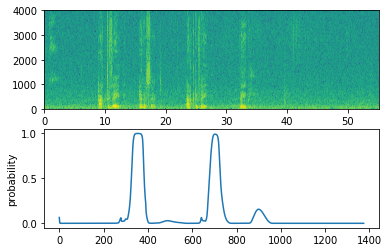

In [35]:
filename = "./raw_data/dev/2.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")
